<# Water Surface Extraction (1985–2024) – Laguna de Fúquene>

## Objective

Analyze the long-term evolution (1985–2024) of the water surface area of Laguna de Fúquene (Colombia)
using satellite-derived data from the JRC Global Surface Water dataset.

This notebook demonstrates:
- Use of remote sensing APIs (Google Earth Engine)
- Time series analysis
- Geospatial decision-oriented analytics
- Reproducible scientific workflows in Python

In [1]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Earth Engine
ee.Initialize(project="earth-observation-fuquene")


In [2]:
# Laguna de Fúquene ROI (editable)
# Región de interés: Laguna de Fúquene (aprox)
fuquene_roi = ee.Geometry.Polygon([
    [
        [-73.82, 5.47],
        [-73.82, 5.35],
        [-73.63, 5.35],
        [-73.63, 5.47],
        [-73.82, 5.47]
    ]
])


In [3]:
Map = geemap.Map(center=[5.43, -73.76], zoom=11)
Map.addLayer(fuquene_roi, {}, "Laguna de Fúquene")
Map

Map(center=[5.43, -73.76], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

In [4]:
gsw = ee.ImageCollection("JRC/GSW1_4/YearlyHistory")



Valores clave:

0 = No data

1 = No water

2 = Water

In [5]:
def water_area_year(year):
    year = ee.Number(year)

    image = (
        ee.ImageCollection("JRC/GSW1_4/YearlyHistory")
        .filter(ee.Filter.eq("year", year))
        .first()
    )

    def compute(img):
        water = img.select("waterClass").gte(2)

        area = (
            water.multiply(ee.Image.pixelArea())
            .reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=fuquene_roi,
                scale=30,
                maxPixels=1e13
            )
            .get("waterClass")
        )

        return ee.Feature(
            None,
            {
                "year": year,
                "water_area_km2": ee.Number(area).divide(1e6)
            }
        )

    return ee.Algorithms.If(
        image,
        compute(image),
        ee.Feature(
            None,
            {
                "year": year,
                "water_area_km2": None
            }
        )
    )
print(water_area_year(2000).getInfo())


{'type': 'Feature', 'geometry': None, 'properties': {'water_area_km2': 11.467713937949744, 'year': 2000}}


In [6]:
years = ee.List.sequence(1985, 2024)
fc = ee.FeatureCollection(years.map(water_area_year))

fc.limit(5).getInfo()

df = geemap.ee_to_df(fc)
df.head()

,water_area_km2,year
0,13.846357,1985
1,13.850145,1986
2,13.593357,1987
3,0.000000,1988
4,12.690626,1989


In [7]:
df = df[['year', 'water_area_km2']].dropna()
df.sort_values('year', inplace=True)
df.head()


,year,water_area_km2
0,1985,13.846357
1,1986,13.850145
2,1987,13.593357
3,1988,0.000000
4,1989,12.690626


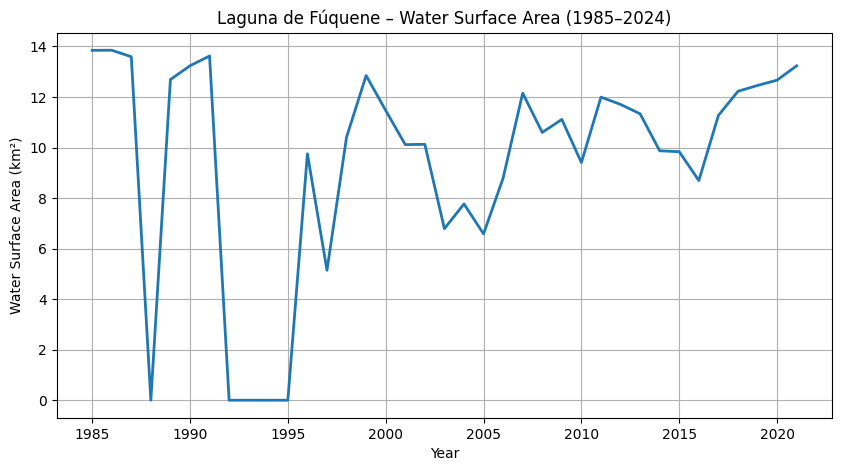

In [8]:
plt.figure(figsize=(10,5))
plt.plot(df['year'], df['water_area_km2'], linewidth=2)
plt.xlabel('Year')
plt.ylabel('Water Surface Area (km²)')
plt.title('Laguna de Fúquene – Water Surface Area (1985–2024)')
plt.grid(True)
plt.show()
